# ORF recognition by Convolutional/Recurrent
Attempting to train the model on simulated RNA sequences of length 512.



In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-07-07 18:24:14 UTC'

In [2]:
#Input
FULL_LENGTH_PC_SEQUENCES = 32000        # how many full-length protein-coding sequences
FULL_LENGTH_NC_SEQUENCES = 32000        # how many full-length non-coding sequences
HALF_LENGTH_PC_SEQUENCES = 32000        # how many half-length protein-coding sequences
HALF_LENGTH_NC_SEQUENCES = 32000        # how many half-length non-coding sequences
PC_TESTS = 1000                         # how many full-length protein-coding sequences used in testing
NC_TESTS = 1000                         # how many full-length non-coding sequences used in testing
RNA_LEN = 512                           # how long is each sequence
CDS_LEN = 256                           # min CDS len to be coding
ALPHABET = 4                            # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN, ALPHABET, 1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN, ALPHABET)       # Conv1D needs 2D inputs

#Model
FILTERS = 32   # how many different patterns the model looks for
CELLS = 128 #Used in LSTM layer(s)
NEURONS = 128 #Used in Dense layer(s)
DROP_RATE = 0.1
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases

#Training
EPOCHS = 25  # how many times to train on all the data
SPLITS = 3  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS = 1 # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
IN_COLAB = False
try:
    from google.colab import drive
    IN_COLAB = True
except:
    pass
if IN_COLAB:
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    from RNA_describe import Random_Base_Oracle
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import prepare_inputs_len_x_alphabet
else:
        print("CoLab not working. On my PC, use relative paths.")
        DATAPATH='data/'  # must end in "/"
        sys.path.append("..") # append parent dir in order to use sibling dirs
        from SimTools.RNA_describe import ORF_counter,Random_Base_Oracle
        from SimTools.RNA_prep import prepare_inputs_len_x_alphabet

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login


On Google CoLab, mount cloud-local file, get our code from GitHub.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
import tensorflow as tf
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import GRU,LSTM
from keras.layers import Flatten,TimeDistributed
from keras.layers import MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
#pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,10) # just testing
#pc_all,nc_all = rbo.get_partitioned_sequences(CDS_LEN,PC_SEQUENCES+PC_TESTS)
#print("Use",len(pc_all),"PC seqs")
#print("Use",len(nc_all),"NC seqs")
rbo=Random_Base_Oracle(RNA_LEN, True)
full_length_pc_train, full_length_nc_train = rbo.get_partitioned_sequences(CDS_LEN, FULL_LENGTH_PC_SEQUENCES)
pc_test, nc_test = rbo.get_partitioned_sequences(CDS_LEN, PC_TESTS)
rbo=Random_Base_Oracle(RNA_LEN // 2, True)
half_length_pc_train, half_length_nc_train = rbo.get_partitioned_sequences(CDS_LEN // 2, HALF_LENGTH_PC_SEQUENCES)
pc_train = full_length_pc_train + half_length_pc_train
nc_train = full_length_nc_train + half_length_nc_train

It took 692694 trials to reach 32000 per class.
It took 22232 trials to reach 1000 per class.
It took 176294 trials to reach 32000 per class.


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())

pc_all = pc_train + pc_test
nc_all = nc_train + nc_test
print("Simulated sequences prior to adjustment:")
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

Simulated sequences prior to adjustment:
PC seqs
Average RNA length: 385.96923076923076
Average ORF length: 228.06327692307693
NC seqs
Average RNA length: 385.96923076923076
Average ORF length: 96.7674


In [7]:
#pc_train=pc_all[:PC_SEQUENCES]
#nc_train=nc_all[:NC_SEQUENCES]
#pc_test=pc_all[PC_SEQUENCES:]
#nc_test=nc_all[NC_SEQUENCES:]

In [8]:
from sklearn.utils import shuffle
def prepare_inputs(pc_seqs, nc_seqs, alphabet_size, with_shuffle=True):
  """
  Different version of code from RNA_prep.prepare_inputs_len_x_alphabet().
  Use until RNA_prep version supports non-uniform RNA lengths.
  """
  samples = pc_seqs + nc_seqs
  num_samples = len(samples)

  y = np.concatenate((np.zeros(len(nc_seqs), dtype=np.int8), np.ones(len(pc_seqs), dtype=np.int8)))
  X = [] #np.empty(num_samples, dtype=object)

  base_to_dim = {'A':0, 'C':1, 'G':2, 'T':3}
  for s in range(0, num_samples):
    sample = samples[s]
    seq_len = len(sample)
    X_seq_shape = (seq_len, alphabet_size)
    X.append([]) #np.zeros(X_seq_shape, dtype=np.int8)
    for b in range(0, seq_len):
      X[s].append([0, 0, 0, 0])
      base = sample[b]
      d = base_to_dim[base]
      X[s][b][d] = 1
  if with_shuffle:
    X,y = shuffle(X, y, random_state=4200)
  return tf.keras.preprocessing.sequence.pad_sequences(X, value=-1),y

X,y = prepare_inputs(pc_train, nc_train, ALPHABET)
print("Data ready.")

Data ready.


In [11]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()

    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())

    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same")) 
    dnn.add(MaxPooling1D())

    dnn.add(LSTM(CELLS,return_sequences=True))
    dnn.add(LSTM(CELLS,return_sequences=False))

    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))
    dnn.add(Dropout(DROP_RATE))

    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))

    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss

    dnn.build() 
    
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (512, 4)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 512, 32)           416       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 512, 32)           3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 256, 32)           0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 256, 32)           3104      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 256, 32)           3104      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)          

In [12]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (512, 4)
FIT
Epoch 1/25
2667/2667 [==============================] - 78s 22ms/step - loss: 0.7008 - accuracy: 0.4959 - val_loss: 0.6940 - val_accuracy: 0.4994


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 2/25
2667/2667 [==============================] - 58s 22ms/step - loss: 0.6936 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 3/25
2667/2667 [==============================] - 58s 22ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6932 - val_accuracy: 0.5006


INFO:tensorflow:Assets written to: BestModel/assets


INFO:tensorflow:Assets written to: BestModel/assets


Epoch 4/25
2667/2667 [==============================] - 58s 22ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 5/25
2667/2667 [==============================] - 58s 22ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 6/25
2667/2667 [==============================] - 59s 22ms/step - loss: 0.6932 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 7/25
2667/2667 [==============================] - 59s 22ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 8/25
2667/2667 [==============================] - 59s 22ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.4994
Epoch 9/25
2667/2667 [==============================] - 58s 22ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5006
Epoch 10/25
2667/2667 [==============================] - 60s 23ms/step - loss: 0.6932 - accuracy: 0.4962 - val_loss: 0.6932 

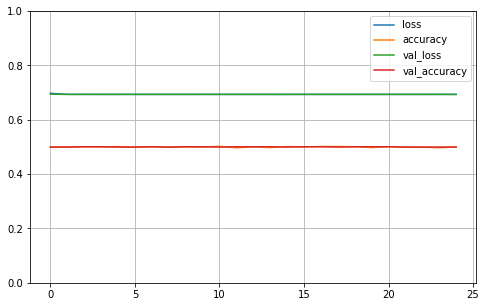

In [13]:
do_cross_validation(X,y)

In [14]:
from keras.models import load_model
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 50.00%


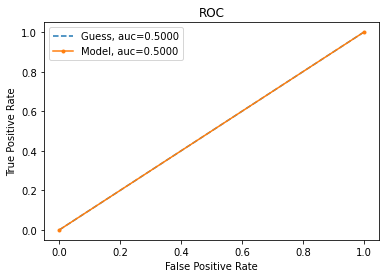

AUC: 50.00%


In [15]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [16]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-07-07 19:02:43 UTC'